In [5]:
from matplotlib import pyplot as plt
import matplotlib.image as mimg

import ipywidgets as ipw
import numpy as np

from astropy.nddata import CCDData, block_reduce
from astropy.visualization import AsymmetricPercentileInterval, LogStretch, ManualInterval

from astrowidgets.bqplot import ImageWidget

# Another color image maker

In [6]:
image_widgets = dict(
    red=ImageWidget(),
    green=ImageWidget(),
    blue=ImageWidget()
)

In [7]:
data_sm = {}
data = {}
sc_raw = {}
sc_raw_f = {}
object_name = ""
def get_scaled_image_data(viewer, data):
    return viewer._get_stretch()(viewer.cuts(data))


In [8]:
def make_image_load_observer(stretches):
    def load_image_data(change):
        global object_name
        obj = change["new"]
        red = CCDData.read(f'combined/combined_light_filter_rp.fit')
        greenish = CCDData.read(f'combined/combined_light_filter_V.fit')
        blue = CCDData.read(f'combined/combined_light_filter_B.fit')

        reduce_fac = 8
        reduce_func = np.mean
        red_sm = block_reduce(red.data, reduce_fac, func=reduce_func)
        green_sm = block_reduce(greenish.data, reduce_fac, func=reduce_func)
        blue_sm = block_reduce(blue.data, reduce_fac, func=reduce_func)

        image_widgets['red'].load_array(red_sm)
        image_widgets['green'].load_array(green_sm)
        image_widgets['blue'].load_array(blue_sm)
        for color in ['red', 'green', 'blue']:
            image_widgets[color].stretch = stretches[color].value
        data_sm['red'] = red_sm
        data_sm['green'] = green_sm
        data_sm['blue'] = blue_sm
        data['red'] = red.data
        data['green'] = greenish.data
        data['blue'] = blue.data
        
        #object_name = obj
    return load_image_data

In [9]:
objects = ipw.Dropdown(description="Choose an object", options=["NGC891", "M1", "M71"])

In [10]:
def make_slider():

    slider = ipw.FloatRangeSlider(min=0, max=100000/64, step=100/64, 
                                  description='Set black and white',
                                  style={'description_width': 'initial'},
                                  continuous_update=False,
                                  layout={'width': '100%'}
                                 )
    return slider

In [11]:
def make_strech_chooser():
    chooser = ipw.Dropdown(options=["linear", "log"], description="Stretch")
    return chooser

In [12]:
level_sliders = dict(
    red=make_slider(),
    green=make_slider(),
    blue=make_slider()
)

stretch_choosers = dict(
    red=make_strech_chooser(),
    green=make_strech_chooser(),
    blue=make_strech_chooser(),
)

In [13]:
def make_observer(color):
    def observer(change):
        minval, maxval = change['new']
        image_widgets[color].cuts = ManualInterval(minval, maxval)
        sc_raw[color] = get_scaled_image_data(image_widgets[color], data_sm[color])
        sc_raw_f[color] = get_scaled_image_data(image_widgets[color], data[color])
        
    return observer

def make_stretch_observer(color):
    def observer(change):
        image_widgets[color].stretch = change['new']
    return observer

load_obs = make_image_load_observer(stretch_choosers)
objects.observe(load_obs, names="value")
load_obs({"new": objects.value})

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## 1. Adjust each of the combined image (red, green, blue) so that the background is black and you can see the detail you want

In [14]:
tab_set = ipw.Tab()
kids = []
boxes = {}
colors = ['red', 'green', 'blue']

for idx, color in enumerate(colors):
    boxes[color] = ipw.VBox(children=[objects, level_sliders[color], stretch_choosers[color], image_widgets[color]])
    this_observer = make_observer(color)
    level_sliders[color].observe(this_observer, names='value')
    this_observer(dict(new=level_sliders[color].value))
    this_stretch_observer = make_stretch_observer(color)
    stretch_choosers[color].observe(this_stretch_observer, names='value')
    kids.append(boxes[color])


tab_set.children = kids
tab_set.titles = colors
tab_set

In [19]:
comb = np.zeros(list(data_sm['red'].shape) + [3])

# red_sc_raw = get_scaled_image_data(image_widgets["red"], data_sm['red'])
# green_sc_raw = get_scaled_image_data(image_widgets["green"], data_sm['green'])
# blue_sc_raw = get_scaled_image_data(image_widgets["blue"], data_sm['blue'])



def quick_color_rgb(r=0.5, g=0.5, b=0.5):
    global comb
    red_sc = r * sc_raw["red"]
    green_sc = g * sc_raw["green"]
    blue_sc = b * sc_raw["blue"]
    comb[:, :, 0] = red_sc
    comb[:, :, 1] = green_sc
    comb[:, :, 2] = blue_sc
    maxes = [np.nanmax(red_sc), np.nanmax(green_sc), np.nanmax(blue_sc)]
    plt.figure(figsize=(8, 8))
    max_img = np.nanmax(comb.flatten())
    plt.title(f'{max_img=:.3f} {r=:.2f} {g=:.2f} {b=:.2f}\n{maxes=}')
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    comb = 4 * comb
    comb[comb > 1] = 1.0
    plt.imshow(comb, vmin=.5, vmax=1)
    #plt.savefig('color.png')

## Adjust the contribution of the red, green and blue images to the final image

In [20]:
ranges = (0, 1, 0.01)
iv = ipw.interact(quick_color_rgb, r=ranges, g=ranges, b=ranges)
iv

interactive(children=(FloatSlider(value=0.5, description='r', max=1.0, step=0.01), FloatSlider(value=0.5, desc…

<function __main__.quick_color_rgb(r=0.5, g=0.5, b=0.5)>

In [21]:
comb_f = np.zeros(list(data['red'].shape) + [3])
def full_res_color_rgb(r=0.5, g=0.5, b=0.5):
    
    red_sc = r * sc_raw_f["red"]
    green_sc = g * sc_raw_f["green"]
    blue_sc = b * sc_raw_f["blue"]
    comb_f[:, :, 0] = red_sc
    comb_f[:, :, 1] = green_sc
    comb_f[:, :, 2] = blue_sc
    maxes = [np.nanmax(red_sc), np.nanmax(green_sc), np.nanmax(blue_sc)]
    plt.figure(figsize=(20, 20))
    max_img = np.nanmax(comb_f.flatten())
    min_img = np.nanmin(comb_f.flatten())
    plt.title(f'{max_img=:.3f} {min_img=:.3f} {r=:.2f} {g=:.2f} {b=:.2f}\n{maxes=}')
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.imshow(2 * comb_f) # , vmin=10) # , vmax=1)
    plt.savefig('full_res_color_' + object_name + '.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.42].


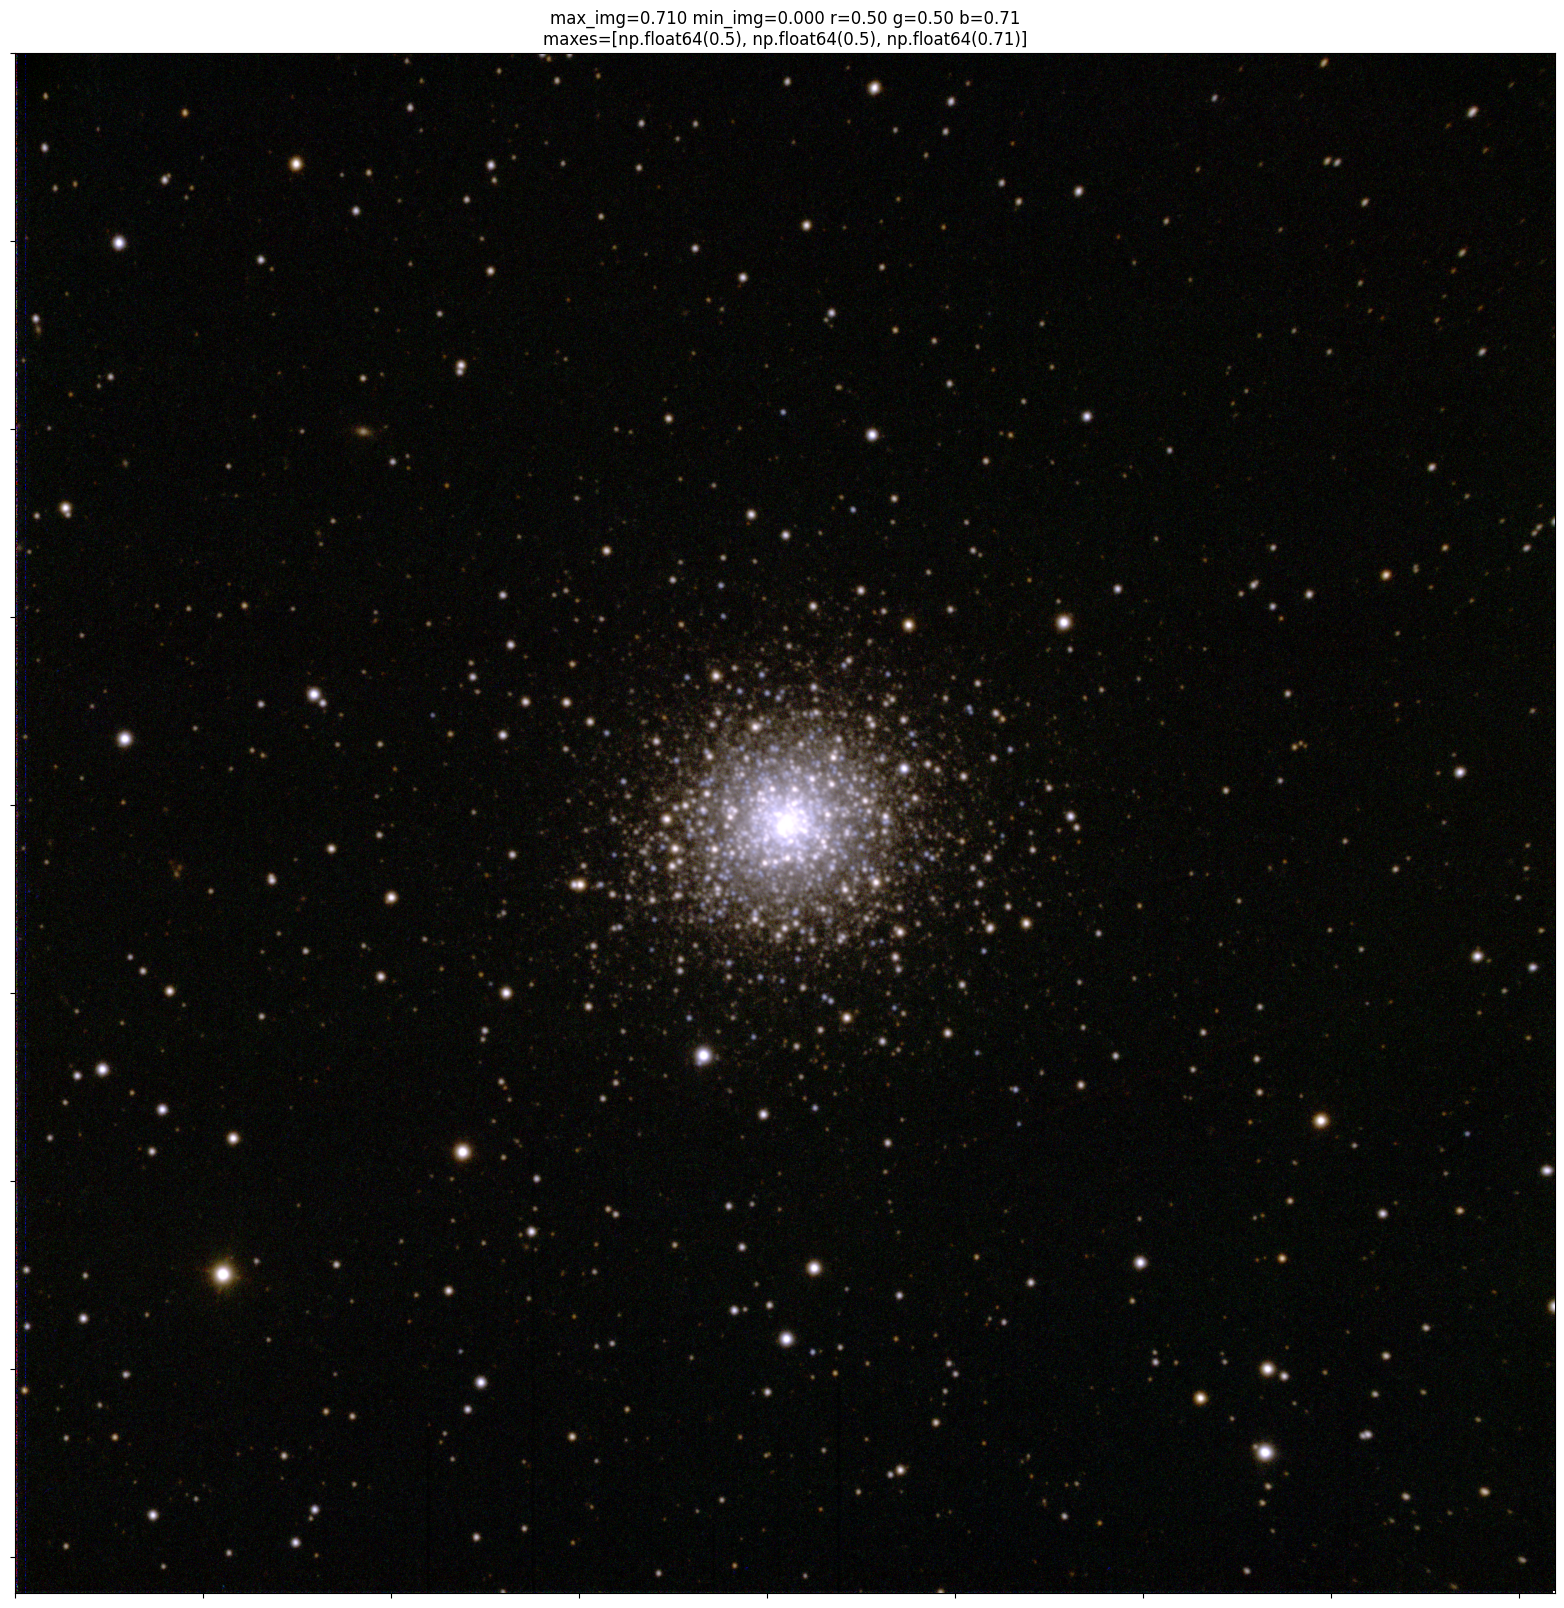

In [22]:
ivw = iv.widget
full_res_color_rgb(ivw.children[0].value, ivw.children[1].value, ivw.children[2].value)